## Water Access and Consumption – Regression Models

Initial dataset shape: (121, 115)

Dropping leakage columns:
['additional_high_cost', 'additional_high_cost.1', 'health_monthly_water_cost', 'health_monthly_water_cost_ssp', 'health_monthly_water_cost_usd', 'high_cost', 'high_cost.1', 'school_monthly_water_cost', 'school_monthly_water_cost_ssp', 'school_monthly_water_cost_usd', 'weekly_water_cost', 'weekly_water_cost_usd']
Remaining columns: 103
Rows after filtering: 121

Train: (96, 102) | Test: (25, 102)

Numeric cols: 54
Categorical cols: 48

----- RandomForest -----
MAE: 96710.18466666667
RMSE: 158955.2146560588
R²: -0.1417695401588892

----- GradientBoosting -----
MAE: 111238.23478280587
RMSE: 165137.0187717389
R²: -0.23230375846143625

----- XGBoost -----
MAE: 100709.905
RMSE: 165755.08143431254
R²: -0.24154537193515258

Model Comparison:

                            MAE           RMSE        R2
RandomForest       96710.184667  158955.214656 -0.141770
GradientBoosting  111238.234783  165137.018772 -0.232304
XGBoost           1007

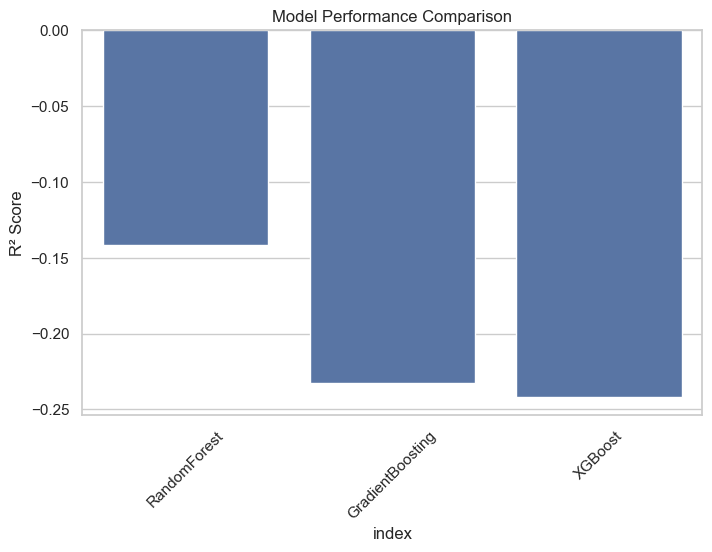

📁 Saved chart: ../5_communication/charts\regression_model_comparison.png

Best model: RandomForest
Saved model: best_model_RandomForest.joblib


<Figure size 640x480 with 0 Axes>

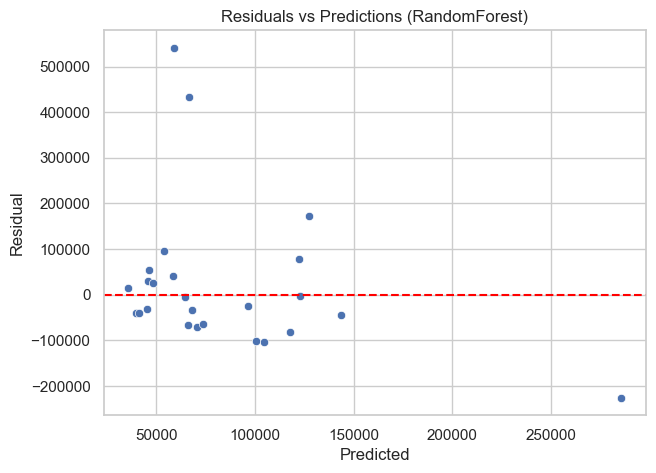

📁 Saved chart: ../5_communication/charts\regression_residuals_vs_predictions.png


<Figure size 640x480 with 0 Axes>

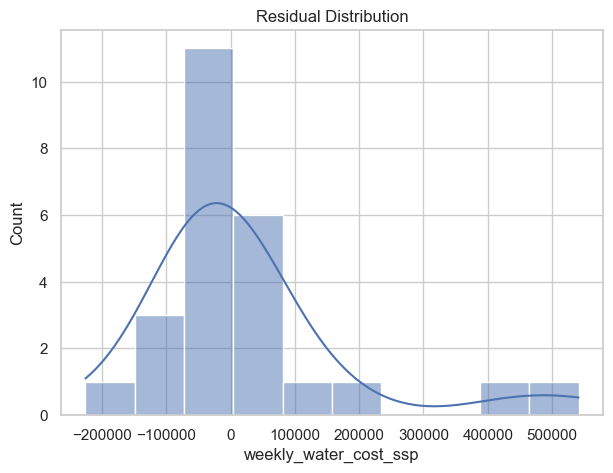

📁 Saved chart: ../5_communication/charts\regression_residual_distribution.png
Saved predictions to predictions_clean.csv

Computing permutation importance...

Top 20 Important Features:
                                              feature  importance
33                          num__additional_more_taps    0.016183
9           num__school_sleep_without_bathing_numeric    0.012859
40                                   num__boreholes.1    0.009737
26                           num__additional_shortage    0.008587
19                                        num__access    0.007601
92             cat__distance_to_water_source_Not far     0.006372
12            num__health_service_disruptions_numeric    0.006088
58                                 cat__age_group_60+    0.004200
74                      cat__primary_income_Hustling     0.003760
29                     num__additional_infrastructure    0.002638
16               num__health_hygiene_problems_numeric    0.002435
51                    

<Figure size 640x480 with 0 Axes>

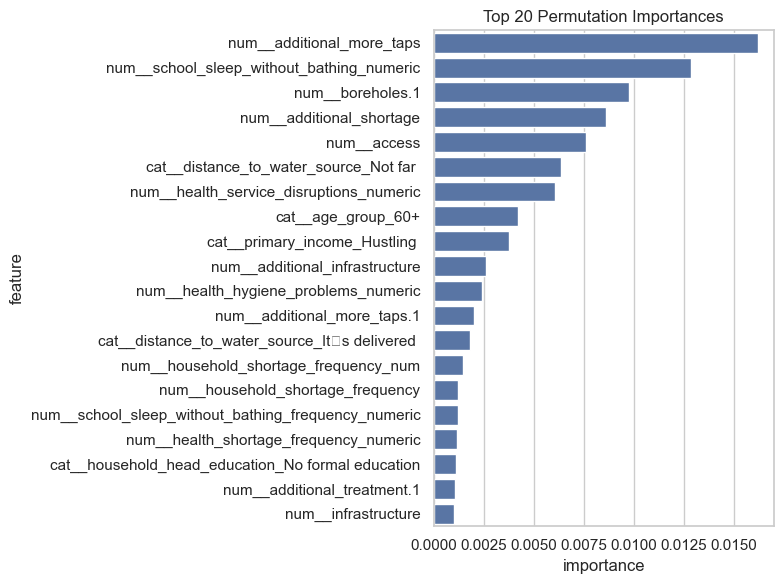

📁 Saved chart: ../5_communication/charts\regression_permutation_importance.png

🎉 Notebook 1 completed successfully!


<Figure size 640x480 with 0 Axes>

In [8]:
# ============================================================
# NOTEBOOK 1 — Regression Model for Predicting Weekly Water Cost (SSP)
# MIT Emerging Talent — Juba Water Analytics Project
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

# ============================================================
# UNIVERSAL CHART-SAVING FUNCTION
# Saves all charts to 5_communication/charts/
# ============================================================

CHART_DIR = "../5_communication/charts"
os.makedirs(CHART_DIR, exist_ok=True)


def save_fig(name, fig=None, dpi=150):
    """Save figure to charts directory."""
    if fig is None:
        fig = plt.gcf()
    path = os.path.join(CHART_DIR, f"{name}.png")
    fig.savefig(path, dpi=dpi, bbox_inches="tight")
    print(f"📁 Saved chart: {path}")


# ============================================================
# LOAD & PREPARE DATA
# ============================================================

df = pd.read_csv("../2_data_preparation/final_cleaned_dataset.csv")
print("Initial dataset shape:", df.shape)

# ============================================================
# REMOVE LEAKAGE COLUMNS (COST-RELATED)
# ============================================================

leakage_patterns = [
    "weekly_water_cost",
    "monthly_water_cost",
    "cost",
    "ssp",
    "usd",
    "high_cost",
]

cols_to_drop = []

for col in df.columns:
    for p in leakage_patterns:
        if p in col.lower() and col != "weekly_water_cost_ssp":
            cols_to_drop.append(col)

cols_to_drop = sorted(list(set(cols_to_drop)))

print("\nDropping leakage columns:")
print(cols_to_drop)

df = df.drop(columns=cols_to_drop)
print("Remaining columns:", len(df.columns))

# ============================================================
# DROP ROWS MISSING TARGET
# ============================================================

df = df.dropna(subset=["weekly_water_cost_ssp"])
print("Rows after filtering:", df.shape[0])

# ============================================================
# DEFINE X, y
# ============================================================

X = df.drop(columns=["weekly_water_cost_ssp"])
y = df["weekly_water_cost_ssp"]

# ============================================================
# TRAIN / TEST SPLIT
# ============================================================

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("\nTrain:", X_train.shape, "| Test:", X_test.shape)

# ============================================================
# COLUMN DETECTION
# ============================================================

numeric_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = X_train.select_dtypes(
    include=["object", "bool", "category"]
).columns.tolist()

print("\nNumeric cols:", len(numeric_cols))
print("Categorical cols:", len(categorical_cols))

# ============================================================
# PREPROCESSOR
# ============================================================

numeric_transformer = Pipeline(
    [("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
    ]
)

preprocessor = ColumnTransformer(
    [
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

# ============================================================
# MODEL DEFINITIONS
# ============================================================

models = {
    "RandomForest": RandomForestRegressor(n_estimators=300, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(),
    "XGBoost": XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=5,
        objective="reg:squarederror",
        random_state=42,
    ),
}

results = {}

# ============================================================
# TRAIN + EVALUATE MODELS
# ============================================================

for name, model in models.items():
    pipe = Pipeline([("preprocess", preprocessor), ("model", model)])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results[name] = {"MAE": mae, "RMSE": rmse, "R2": r2}

    print(f"\n----- {name} -----")
    print("MAE:", mae)
    print("RMSE:", rmse)
    print("R²:", r2)

# ============================================================
# MODEL COMPARISON — CHART SAVED
# ============================================================

results_df = pd.DataFrame(results).T
print("\nModel Comparison:\n")
print(results_df)

plt.figure(figsize=(8, 5))
sns.barplot(data=results_df.reset_index(), x="index", y="R2")
plt.xticks(rotation=45)
plt.ylabel("R² Score")
plt.title("Model Performance Comparison")
plt.show()
save_fig("regression_model_comparison")

# ============================================================
# SELECT BEST MODEL
# ============================================================

best_model_name = results_df["R2"].idxmax()
print("\nBest model:", best_model_name)

best_model = models[best_model_name]

# ============================================================
# TRAIN FINAL PIPELINE & SAVE IT
# ============================================================

best_pipeline = Pipeline([("preprocess", preprocessor), ("model", best_model)])

best_pipeline.fit(X_train, y_train)
joblib.dump(best_pipeline, f"best_model_{best_model_name}.joblib")

print(f"Saved model: best_model_{best_model_name}.joblib")

# ============================================================
# RESIDUAL ANALYSIS — CHARTS SAVED
# ============================================================

y_pred_best = best_pipeline.predict(X_test)
residuals = y_test - y_pred_best

# Scatter: predicted vs residuals
plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_pred_best, y=residuals)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.title(f"Residuals vs Predictions ({best_model_name})")
plt.show()
save_fig("regression_residuals_vs_predictions")

# Histogram of residuals
plt.figure(figsize=(7, 5))
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution")
plt.show()
save_fig("regression_residual_distribution")

# ============================================================
# SAVE PREDICTIONS
# ============================================================

pred_df = pd.DataFrame(
    {"actual": y_test, "predicted": y_pred_best, "residual": residuals}
)
pred_df.to_csv("predictions_clean.csv", index=False)
print("Saved predictions to predictions_clean.csv")

# ============================================================
# PERMUTATION IMPORTANCE — CHART SAVED OPTIONAL
# ============================================================

print("\nComputing permutation importance...")

pre = best_pipeline.named_steps["preprocess"]
pre.fit(X_train)
feature_names = pre.get_feature_names_out()

pi = permutation_importance(
    best_pipeline, X_test, y_test, n_repeats=10, random_state=42
)

n_features = len(pi.importances_mean)
feature_names = feature_names[:n_features]

imp_df = pd.DataFrame(
    {"feature": feature_names, "importance": pi.importances_mean}
).sort_values("importance", ascending=False)

print("\nTop 20 Important Features:")
print(imp_df.head(20))

imp_df.to_csv("permutation_importance_clean.csv", index=False)

# Plot importance
plt.figure(figsize=(8, 6))
sns.barplot(data=imp_df.head(20), x="importance", y="feature")
plt.title("Top 20 Permutation Importances")
plt.tight_layout()
plt.show()
save_fig("regression_permutation_importance")

print("\n🎉 Notebook 1 completed successfully!")